In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Path & Settings
image_dir = "dataset_images"
img_size = 96
classes = ["positive", "negative"]

# Image preprocessing
images = []
labels = []

for label_idx, label_name in enumerate(classes):
    folder_path = os.path.join(image_dir, label_name)
    for file in os.listdir(folder_path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size)) #resize
            img = np.expand_dims(img, axis=-1) #expand dimension
            images.append(img)
            labels.append(label_idx)  # 0=positive, 1=negative

images = np.array(images)
labels = np.array(labels)

print(f"# of images: {len(images)}")

# Train/Val/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, stratify=labels, random_state=42, shuffle = True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42, shuffle = True
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# of images: 2017
Train: (1411, 96, 96, 1) Val: (406, 96, 96, 1) Test: (200, 96, 96, 1)


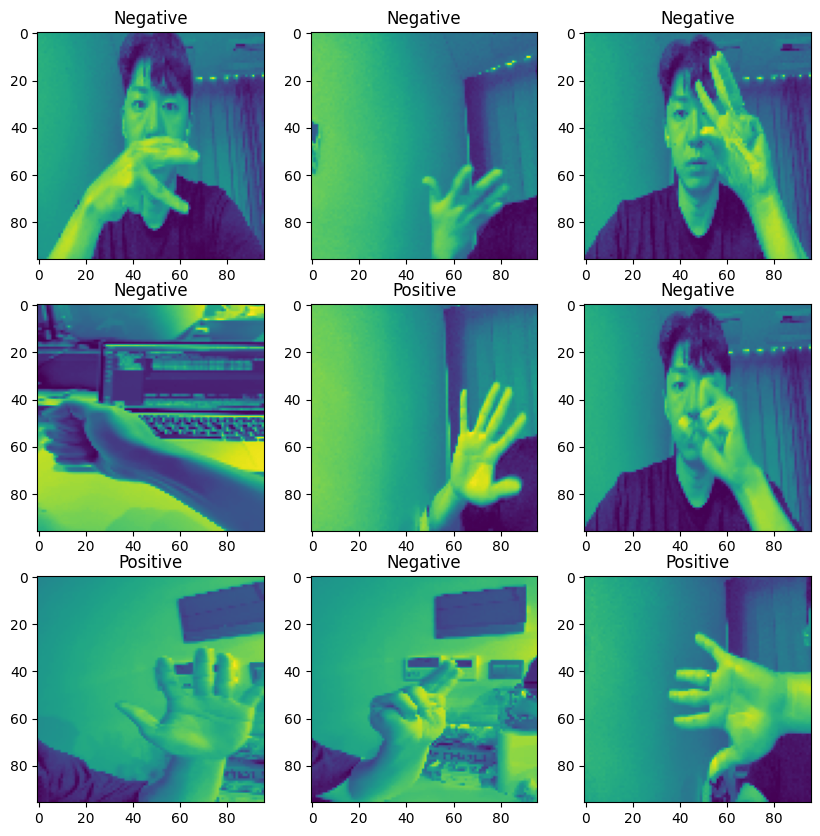

In [3]:
#Image visualization
labels_string = {1:"Negative", 0:"Positive"}

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i+600])
    plt.title(labels_string[y_train[i+600]])

plt.show()

In [4]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle & Batch & Prefetch
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [5]:
from tensorflow.keras import layers, models
import tensorflow_model_optimization as tfmot

inputs = layers.Input(shape=(96, 96, 1))

# Block 1
x = layers.DepthwiseConv2D((3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(8, (1,1), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Block 2
x = layers.DepthwiseConv2D((3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(16, (1,1), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Block 3
x = layers.Conv2D(4, (1,1), activation='relu')(x)
x = layers.Flatten()(x)

# output
outputs = layers.Dense(2, activation='softmax')(x)

# Functional API Model
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 96, 96, 1)         10        
 eConv2D)                                                        
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 8)         16        
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 8)         0         
 D)                                                              
                                                                 
 depthwise_conv2d_1 (Depthw  (None, 48, 48, 8)         80        
 iseConv2D)                                                      
                                                             

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stop]
)

Epoch 1/200
45/45 [==============================] - 1s 27ms/step - loss: 0.6684 - accuracy: 0.6279 - val_loss: 0.6581 - val_accuracy: 0.6305
Epoch 2/200
45/45 [==============================] - 1s 24ms/step - loss: 0.6500 - accuracy: 0.6308 - val_loss: 0.6341 - val_accuracy: 0.6305
Epoch 3/200
45/45 [==============================] - 1s 24ms/step - loss: 0.5765 - accuracy: 0.6471 - val_loss: 0.4764 - val_accuracy: 0.7931
Epoch 4/200
45/45 [==============================] - 1s 25ms/step - loss: 0.3231 - accuracy: 0.9036 - val_loss: 0.1848 - val_accuracy: 0.9483
Epoch 5/200
45/45 [==============================] - 1s 24ms/step - loss: 0.1325 - accuracy: 0.9568 - val_loss: 0.1103 - val_accuracy: 0.9606
Epoch 6/200
45/45 [==============================] - 1s 23ms/step - loss: 0.0874 - accuracy: 0.9702 - val_loss: 0.0925 - val_accuracy: 0.9680
Epoch 7/200
45/45 [==============================] - 1s 23ms/step - loss: 0.0767 - accuracy: 0.9702 - val_loss: 0.0930 - val_accuracy: 0.9754
Epoch 

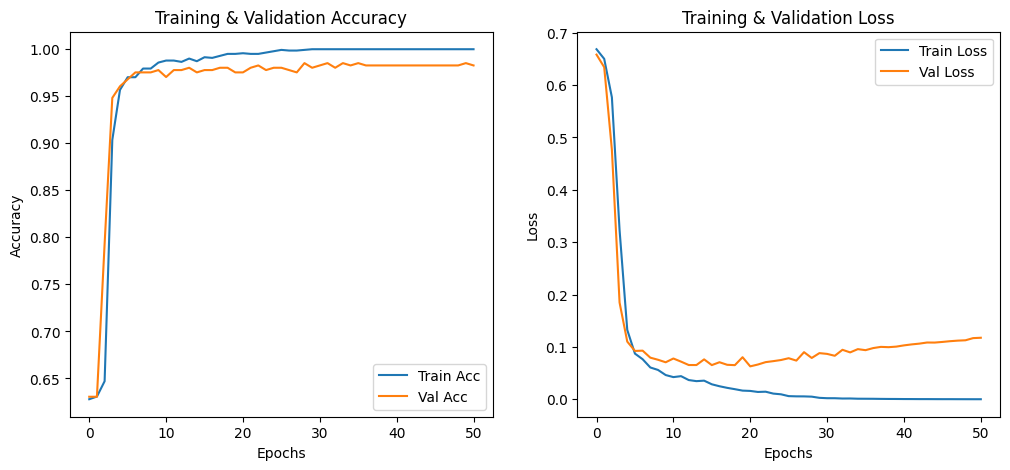

In [7]:
import matplotlib.pyplot as plt

# training visualization
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

In [8]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")

7/7 [==============================] - 0s 12ms/step - loss: 0.0529 - accuracy: 0.9750
Test Accuracy: 0.9750


In [9]:
def representative_data_gen():
    for images, _ in train_ds.take(100):
        for img in images:
            img = tf.cast(img, tf.float32)
            img = tf.expand_dims(img, axis=0)  # (96,96,1) → (1,96,96,1)
            yield [img]                 # shape (96,96,1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# For Arduino compatibility
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.experimental_new_converter = False 

tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
  
# Convert tflite to cc
os.system("xxd -i model.tflite > model.cc")

INFO:tensorflow:Assets written to: /var/folders/r6/tpy3wyhx3fn9dpy0yrzv530h0000gn/T/tmpgqqdt7dm/assets


INFO:tensorflow:Assets written to: /var/folders/r6/tpy3wyhx3fn9dpy0yrzv530h0000gn/T/tmpgqqdt7dm/assets
2025-08-06 15:24:29.471619: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-08-06 15:24:29.471718: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-08-06 15:24:29.505223: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-08-06 15:24:29.505284: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
/Users/wonminkim/Library/Mobile Documents/com~apple~CloudDocs/Current/Projects/kws_gesture/.venv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.

0

In [10]:
# Check shapes
model = tf.lite.Interpreter(model_path="model.tflite")
model.allocate_tensors()

print(model.get_input_details())
print(model.get_output_details())

[{'name': 'input_1', 'index': 0, 'shape': array([ 1, 96, 96,  1], dtype=int32), 'shape_signature': array([ 1, 96, 96,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 21, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([1, 2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
# Check the ops
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
for detail in interpreter.get_tensor_details():
    print(detail['name'])


input_1
model/dense/MatMul_bias
model/dense/MatMul/ReadVariableOp/transpose
model/conv2d_2/Conv2D_bias
model/conv2d_2/Conv2D/ReadVariableOp
model/conv2d_1/Conv2D_bias
model/conv2d_1/Conv2D/ReadVariableOp
model/depthwise_conv2d_1/depthwise_bias
model/depthwise_conv2d_1/depthwise/ReadVariableOp
model/conv2d/Conv2D_bias
model/conv2d/Conv2D/ReadVariableOp
model/depthwise_conv2d/depthwise_bias
model/depthwise_conv2d/depthwise/ReadVariableOp
model/depthwise_conv2d/Relu
model/conv2d/Relu
model/max_pooling2d/MaxPool
model/depthwise_conv2d_1/Relu
model/conv2d_1/Relu
model/max_pooling2d_1/MaxPool
model/conv2d_2/Relu
model/dense/BiasAdd
Identity
